In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

# load cardiovascular disease dataset
dataset = np.loadtxt('cardio_train.csv', delimiter=';', skiprows=1)
data = dataset[:, 1:-1]
target = dataset[:, -1:]

[age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active]

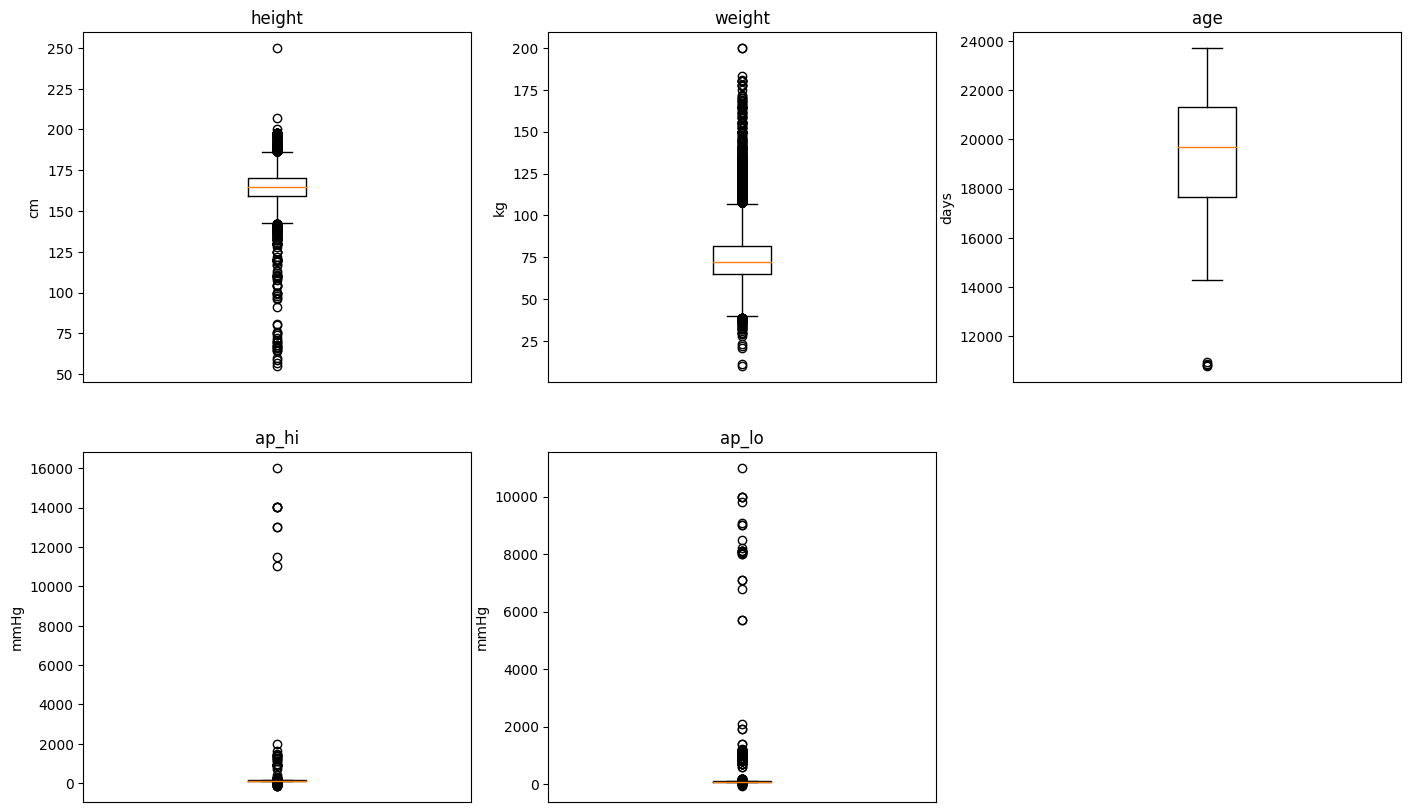

In [ ]:
# show box plots for all continous value features to see distributions
fig = plt.figure(figsize=(17, 10))

fig.add_subplot(2, 3, 1)
plt.boxplot(data[:,2])
plt.xticks([])
plt.ylabel('cm')
plt.title('height')

fig.add_subplot(2, 3, 2)
plt.boxplot(data[:,3])
plt.xticks([])
plt.ylabel('kg')
plt.title('weight')

fig.add_subplot(2, 3, 3)
plt.boxplot(data[:,0])
plt.xticks([])
plt.ylabel('days')
plt.title('age')

fig.add_subplot(2, 3, 4)
plt.boxplot(data[:,4])
plt.xticks([])
plt.ylabel('mmHg')
plt.title('ap_hi')

fig.add_subplot(2, 3, 5)
plt.boxplot(data[:,5])
plt.xticks([])
plt.ylabel('mmHg')
plt.title('ap_lo')

plt.show()

In [ ]:
# threshold data to remove impossible values
bad = []
for i in range(len(data)):
  # height
  if data[i][2] > 220 or data[i][2] < 140:
    if i not in bad:
      bad.append(i)
  # weight
  if data[i][3] < 35:
    if i not in bad:
      bad.append(i)
  # ap_hi
  if data[i][4] > 370 or data[i][4] < 1:
    if i not in bad:
      bad.append(i)
  # ap_lo
  if data[i][5] > 360 or data[i][5] < 1:
    if i not in bad:
      bad.append(i)

bad = sorted(bad)
for i in range(len(bad)):
  data = np.delete(data, bad[-(i+1)],0)
  target = np.delete(target,bad[-(i+1)],0)


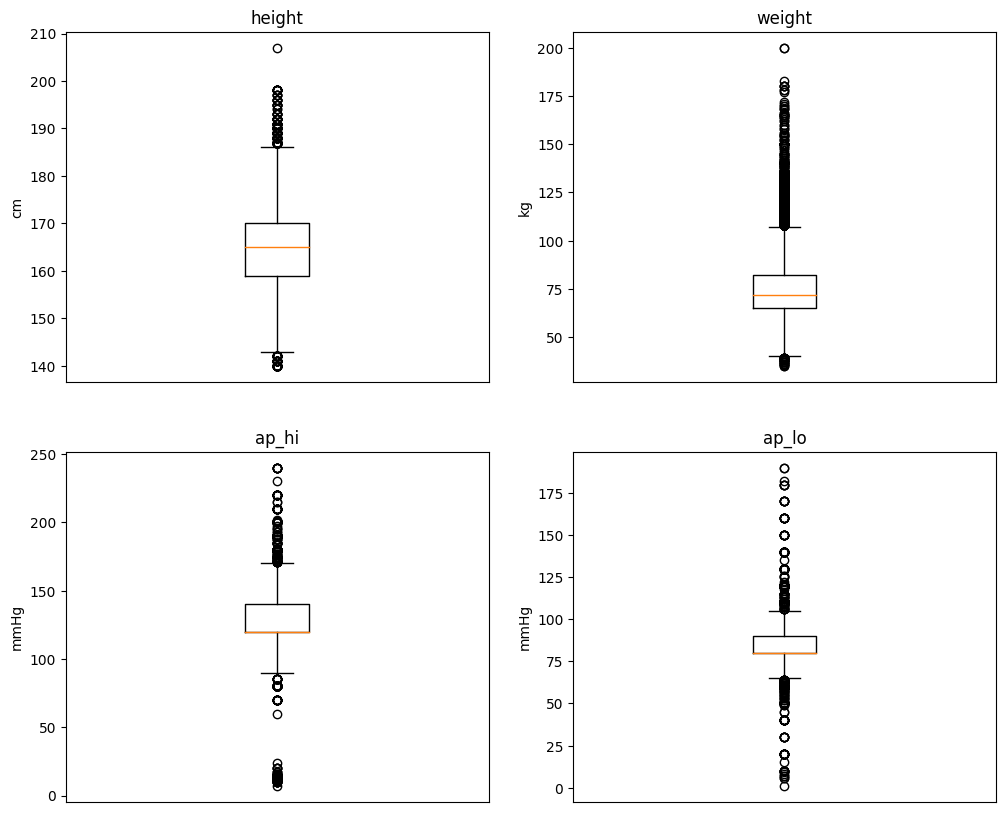

In [ ]:
# show box plots for thresholded features to see improved distributions
fig = plt.figure(figsize=(12, 10))

fig.add_subplot(2, 2, 1)
plt.boxplot(data[:,2])
plt.xticks([])
plt.ylabel('cm')
plt.title('height')

fig.add_subplot(2, 2, 2)
plt.boxplot(data[:,3])
plt.xticks([])
plt.ylabel('kg')
plt.title('weight')

fig.add_subplot(2, 2, 3)
plt.boxplot(data[:,4])
plt.xticks([])
plt.ylabel('mmHg')
plt.title('ap_hi')

fig.add_subplot(2, 2, 4)
plt.boxplot(data[:,5])
plt.xticks([])
plt.ylabel('mmHg')
plt.title('ap_lo')

plt.show()

In [ ]:
def cmplot(cm, title):
    sns.set(font_scale=1.1)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(title)
    plt.tick_params(bottom=False, left=False)
    plt.show()
    return

In [ ]:
# -------MLP-------

X_train,X_test,y_train,y_test = train_test_split(data,target.ravel(), test_size=0.1)
clf = MLPClassifier(hidden_layer_sizes=(2),random_state=50,verbose=False,learning_rate_init=0.01)

clf.fit(X_train,y_train)
ypred = clf.predict(X_test)
accuracy = accuracy_score(y_test,ypred)
# store y_test vals, ypred vals, (so we can get accuracies), and hidden layers shape
best = [y_test, ypred, (2)]


def MLP(d1,t1,testsize,hiddenshape,learnrate):
  X_train,X_test,y_train,y_test = train_test_split(d1,t1.ravel(), test_size=testsize)
  clf = MLPClassifier(hidden_layer_sizes=hiddenshape,random_state=50,verbose=False,learning_rate_init=learnrate)

  clf.fit(X_train,y_train)
  ypred = clf.predict(X_test)
  accuracy = accuracy_score(y_test,ypred)
  #print("Accuracy: ", accuracy)
  global best
  if accuracy > (accuracy_score(best[0],best[1])): # if we found a more accurate model
    best = [y_test,ypred,hiddenshape]

  return (accuracy,hiddenshape)



accuracies = []
for i in range(5): # random mlp hidden layers, find most accurate
  a = random.randint(4,15)
  b = random.randint(4,15)
  c = random.randint(4,15)
  accuracies.append(MLP(data,target,.1,(i+4),0.01))
  accuracies.append(MLP(data,target,.1,(i+4,i+4),0.01))
  accuracies.append(MLP(data,target,.1,(i+4,i+4,i+4),0.01))
  accuracies.append(MLP(data,target,.1,(a),0.01))
  accuracies.append(MLP(data,target,.1,(a,b),0.01))
  accuracies.append(MLP(data,target,.1,(a,b,c),0.01))
a = []
for i in range(len(accuracies)):
  a.append(accuracies[i][0])
a = sorted(a,reverse=True)

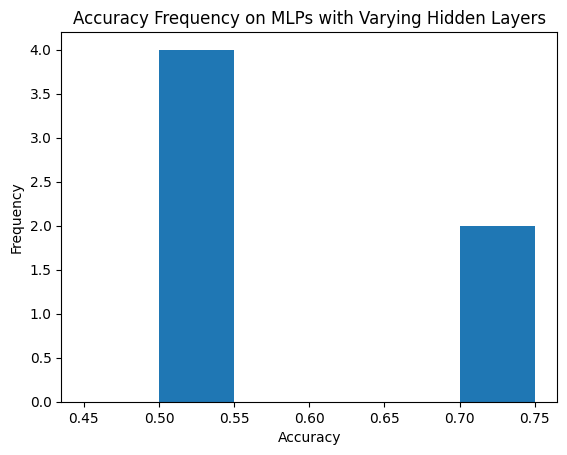

In [ ]:

plt.hist(a,bins=[.45,.5,.55,.6,.65,.7,.75])
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Accuracy Frequency on MLPs with Varying Hidden Layers")

plt.show()


Best performance over 30 runs
accuracy: 0.7234815460621912
precision: 0.7589134125636672
recall: 0.6519836639439907


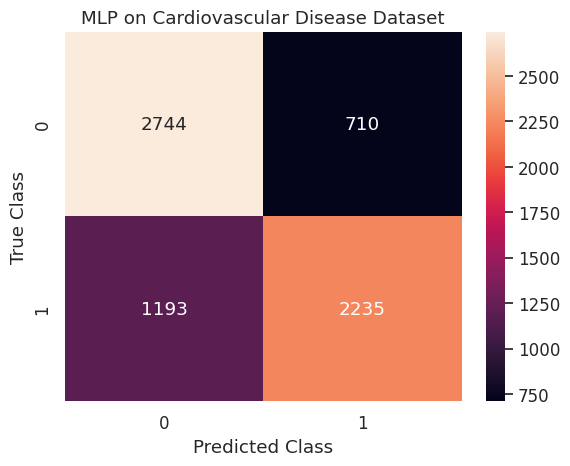

In [ ]:
# analysis of MLP
y_test, y_pred = best[0],best[1]
print('Best performance over ' + str(30) + ' runs')
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cmplot(cm, 'MLP on Cardiovascular Disease Dataset')

In [ ]:
# -------SVM-------
def SVM(kernel_type, random_state=None):
  X_train, X_test, y_train, y_test = train_test_split(data, target.ravel(), test_size=0.1, random_state = random_state)
  clf = svm.SVC(kernel=kernel_type)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  return y_test, y_pred

In [ ]:
# identify kernel that gives highest accuracy
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for k in kernels:
  print('\nkernel=' + k)
  y_test, y_pred = SVM(k, random_state=42)
  print("accuracy:", accuracy_score(y_test, y_pred))


kernel=linear


Best performance over 5 runs
accuracy: 0.7124285714285714
precision: 0.7387359198998749
recall: 0.6671376094942074


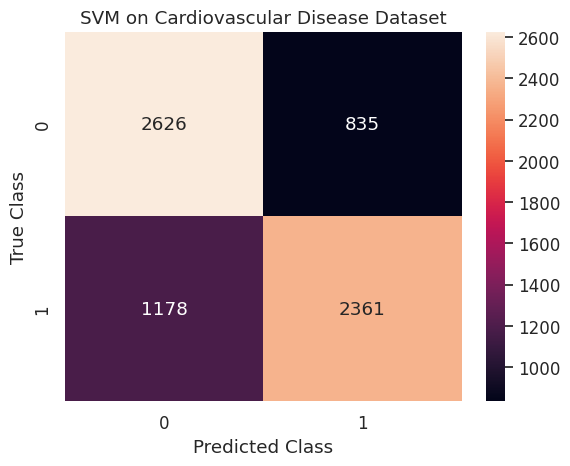

In [ ]:
# get best performance over a number of random initializations
runs = 5
best_accuracy = 0
for i in range(runs):
    y_test, y_pred = SVM('linear')

    if accuracy_score(y_test, y_pred) > best_accuracy:
        best_results = (y_test, y_pred)


y_test, y_pred = best_results
print('Best performance over ' + str(runs) + ' runs')
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cmplot(cm, 'SVM on Cardiovascular Disease Dataset')


In [ ]:
# -------Logistic Regression-------
def logistic_regression_experiment(data, target, random_state=42):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target.ravel(), test_size=0.1, random_state=random_state)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define Logistic Regression model
    model = LogisticRegression()

    # Define hyperparameters to search
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]

    # Define grid search
    grid = dict(solver=solvers, penalty=penalty, C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
    grid_result = grid_search.fit(X_train_scaled, y_train)

    # Summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    # Evaluate the best model on the test set
    best_model = grid_result.best_estimator_
    test_accuracy = best_model.score(X_test_scaled, y_test)
    print("Test Accuracy:", test_accuracy)
    print("Best Hyperparameters:", best_model.get_params())

# Call the method with data and target
logistic_regression_experiment(data, target)

Best: 0.720243 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.720243 (0.004650) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.720233 (0.004644) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.720238 (0.004647) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.720222 (0.004659) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.720222 (0.004659) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.720233 (0.004667) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.720005 (0.004704) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.720005 (0.004704) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.720005 (0.004705) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.717550 (0.004625) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.717561 (0.004625) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.717556 (0.004597) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.699730 (0.004395) wit

The best combination of hyperparameters that achieved highest cross-validated accuracy is C:100, Penalty: L2, Solver: newton-cg

In [ ]:
def evaluate_best_logistic_regression(data, target, random_state=42):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target.ravel(), test_size=0.1, random_state=random_state)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the best Logistic Regression model using the best hyperparameters
    best_model = LogisticRegression(C=100, penalty='l2', solver='newton-cg')

    # Train the model on the standardized training data
    best_model.fit(X_train_scaled, y_train)

    # Make predictions on the standardized test data
    y_pred = best_model.predict(X_test_scaled)

    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return y_test, y_pred

Best performance over 5 runs
accuracy: 0.7298571428571429
precision: 0.7527524378735452
recall: 0.6841052029731275


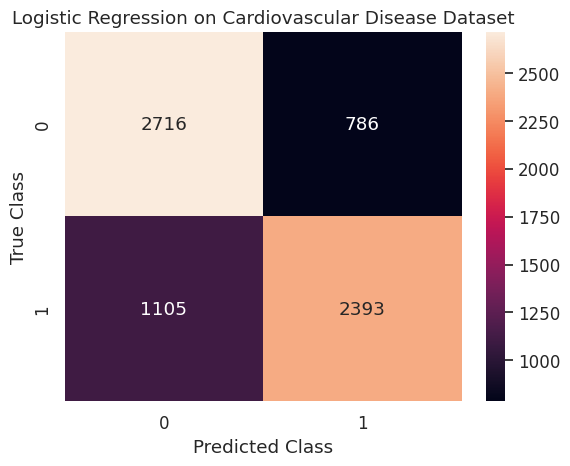

(array([1., 1., 1., ..., 0., 1., 0.]), array([1., 1., 1., ..., 0., 0., 0.]))

In [ ]:
#get best performance of Logistic Regression over 5 runs
runs = 5
best_accuracy = 0
for i in range(runs):
    y_test, y_pred = evaluate_best_logistic_regression(data,target)

    if accuracy_score(y_test, y_pred) > best_accuracy:
        best_results = (y_test, y_pred)


y_test, y_pred = best_results
print('Best performance over ' + str(runs) + ' runs')
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cmplot(cm, 'Logistic Regression on Cardiovascular Disease Dataset')

# Call the method with data and target
evaluate_best_logistic_regression(data, target)

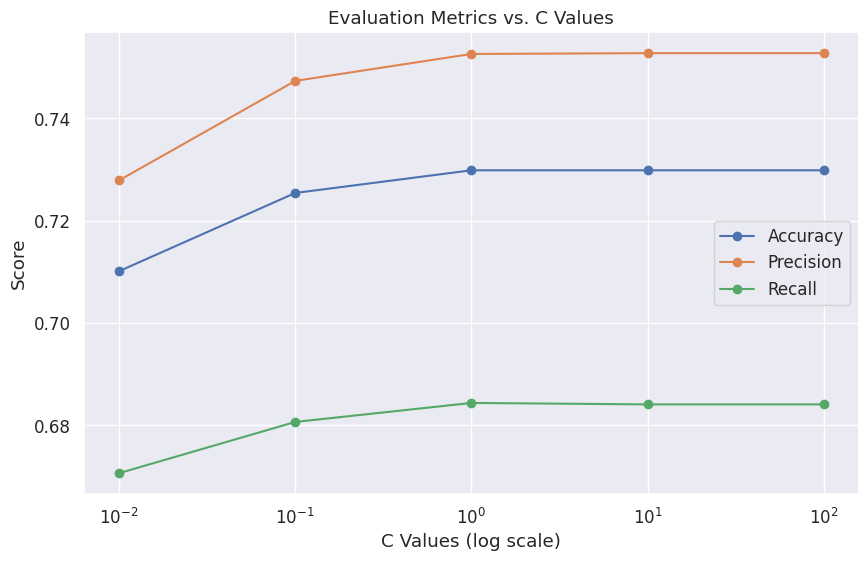

In [ ]:
def plot_C_vals_best_logistic_regression(data, target, c_values, random_state=42):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target.ravel(), test_size=0.1, random_state=random_state)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Lists to store evaluation metrics for each C value
    accuracy_scores = []
    precision_scores = []
    recall_scores = []

    for c in c_values:
        # Define the Logistic Regression model with the current C value
        model = LogisticRegression(C=c, penalty='l2', solver='newton-cg')

        # Train the model on the standardized training data
        model.fit(X_train_scaled, y_train)

        # Make predictions on the standardized test data
        y_pred = model.predict(X_test_scaled)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Append metrics to lists
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)

    # Plot evaluation metrics for different C values
    plt.figure(figsize=(10, 6))
    plt.plot(c_values, accuracy_scores, marker='o', label='Accuracy')
    plt.plot(c_values, precision_scores, marker='o', label='Precision')
    plt.plot(c_values, recall_scores, marker='o', label='Recall')
    plt.xscale('log')
    plt.xlabel('C Values (log scale)')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics vs. C Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# List of C values to test
c_values = [100, 10, 1.0, 0.1, 0.01]

# Call the method with data, target, and C values
plot_C_vals_best_logistic_regression(data, target, c_values, random_state=42)